# はじめに
DP-SGDで教師データのプライバシーを保護しつつ、高いテスト精度を実現することを目指します。  
学習は以前の[Jupyter Notebook](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/1_DPSGD_baseline.ipynb)をベースにしています。

### 概要
- CIFAR-10の学習に、[Opacus](https://opacus.ai/)を用いてDP-SGDを適用する。
- 異なるニューラルネットワークのテスト精度を確認する。


### 参考資料
- Building an Image Classifier with Differential Privacy (Opacus Tutorials)  
https://opacus.ai/tutorials/building_image_classifier
- PyTorch Quickstart  
https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html


# 実装

### 1. ライブラリのインポート
必要なライブラリをインポートします。


In [ ]:
import torch
import torchvision
from torch.utils.data import DataLoader
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

!pip install 'opacus>=1.0'
import opacus
from opacus.validators import ModuleValidator
from opacus.utils.batch_memory_manager import BatchMemoryManager

import warnings
warnings.simplefilter("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 10.8 MB/s eta 0:00:00


### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  
Opacusは1.0.0で書き方が大きく変わっているので注意してください。  
[Google Colaboratory](https://colab.research.google.com/?hl=ja)で実行した際の例になります。

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
print('Torchvision:', torchvision.__version__)
print('Opacus:', opacus.__version__)
!nvidia-smi

Python: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
PyTorch: 2.0.0+cu118
Torchvision: 0.15.1+cu118
Opacus: 1.4.0
Thu Apr 13 12:19:09 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------

### 3. データセットの用意  

#### データセットの取得
カラー画像データセットの[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)を、torchvisionを用いて取得します。  
[以前の結果](https://github.com/toshi-4886/privacy_preserving_ML/blob/main/PyTorch/2_DPSGD_regularization.ipynb)に基づいて、教師データにdata augmentationは適用せずに、前処理は下記のみを適用します。
- ToTensor：データをTensor型に変換
- Normalize：各チャネルの平均が0、標準偏差が1となるように標準化


In [ ]:
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD = (0.2470, 0.2435, 0.2616)

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)


test_data = torchvision.datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(), 
        torchvision.transforms.Normalize(CIFAR10_MEAN, CIFAR10_STD)]),
)

100%|██████████| 170498071/170498071 [00:13<00:00, 12781353.95it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### 4. ニューラルネットワークの定義  
今回は、シンプルなニューラルネットワークのテスト精度も確認します。  
[サンプルコード](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html)を参考に5層のネットワークを定義します。

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
# https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 3 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(64 * 5 * 5, 1024)  # 5*5 from image dimension
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### 5. 学習の関数化
異なる条件で複数回学習を実行するため、学習部分を関数として定義します。  
各エポックのテスト精度と消費した$\epsilon$を出力します。

In [ ]:
def training(optim='Adam', lr=1e-3, batch_size = 512, sigma=1.0, c=1.0, network='ResNet'):    
    # make dataloader
    train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=1024, shuffle=False)

    # make model
    if network == 'ResNet':
        model = torchvision.models.resnet18()
    elif network == 'EfficientNet':
        model = torchvision.models.efficientnet_b0()
    elif network == 'MobileNet':
        model = torchvision.models.mobilenet_v3_small()
    elif network == 'CNN':
        model = Net()
    model = ModuleValidator.fix(model)

    device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    model = model.to(device)

    # make optimizer
    criterion = torch.nn.CrossEntropyLoss()
    if optim == 'Adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optim == 'RMSprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=1e-4)
    elif optim == 'MSGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr,  momentum=0.9, weight_decay=1e-4)
    elif optim == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=1e-4)

    # DP-SGD settig
    privacy_engine = opacus.PrivacyEngine()
    model, optimizer, train_dataloader = privacy_engine.make_private(
        module=model,
        optimizer=optimizer,
        data_loader=train_dataloader,
        noise_multiplier=sigma,
        max_grad_norm=c,
    )

    # training 
    test_acc = []
    epsilon = []

    pbar = tqdm(range(15), desc=f"[{network}]")
    for epoch in pbar:
            
        with BatchMemoryManager(
            data_loader=train_dataloader, 
            max_physical_batch_size=32, 
            optimizer=optimizer
        ) as memory_safe_data_loader:
            model.train()
            for (X, y) in memory_safe_data_loader:
                X, y = X.to(device), y.to(device)

                # optimization step
                optimizer.zero_grad()
                pred = model(X)
                loss = criterion(pred, y)
                loss.backward()
                optimizer.step()

        # calculate epsilon
        epsilon.append(privacy_engine.get_epsilon(1e-5))
    
        # test
        model.eval()
        pred_list = []
        y_list = []
        with torch.no_grad():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)

                # predict
                pred = model(X)
                loss = criterion(pred, y)

                y_list.extend(y.to('cpu').numpy().tolist())
                pred_list.extend(pred.argmax(1).to('cpu').numpy().tolist())

        test_acc.append(metrics.accuracy_score(y_list, pred_list))
        pbar.set_postfix(epsilon=epsilon[-1],test_acc=test_acc[-1])
    return epsilon, test_acc
    

### 6. 学習
先ほど定義したシンプルなネットワーク（CNN）とtorchvisionで用意されているネットワーク（MobileNet, EfficientNet, ResNet）の学習を行います。  
入力サイズやメモリ容量の関係で、学習可能なネットワークを試しています。

In [ ]:
result = {}

for network in ['CNN', 'MobileNet', 'EfficientNet', 'ResNet']:
        epsilon, test_acc = training(network=network)
        result[network] = (epsilon, test_acc)

[ResNet]: 100%|██████████| 15/15 [24:45<00:00, 99.07s/it, epsilon=2.27, test_acc=0.506]


### 7. 学習結果の表示
学習結果として、消費した$\epsilon$とテストデータの精度を描画します。

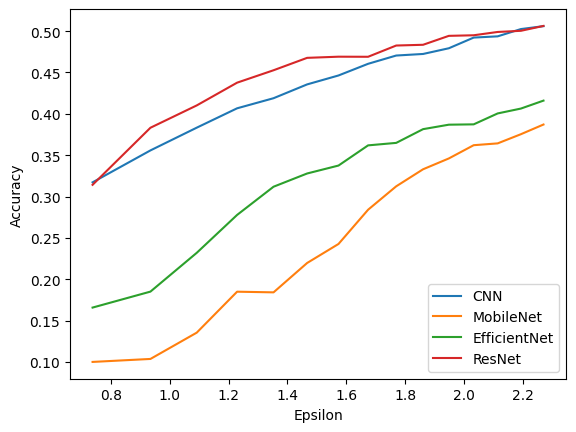

In [ ]:

for val, res in result.items():
    epsilon, test_acc = res
    plt.plot(epsilon, test_acc, label=val)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# おわりに

### 今回の結果
シンプルなネットワークCNNとResNetが同等のテスト精度となりました。  
他のネットワークはそれよりも劣る結果となりました。  

シンプルなネットワークでも比較的高いテスト精度となっていることから、DP-SGDで高いテスト精度を実現するためには、DP-SGDと相性の良いネットワークを用いることが必要なことが分かります。  
今後もネットワークはResNetを用いようと思います。


### 次にやること
DP-SGDでどの程度教師データのプライバシーが守られているか検証したいと思います。